Run export of CSV file from mongdodb

1. 

In [1]:
import pandas as pd
import geopandas as gpd
print(pd.__version__)

1.4.1


In [8]:
''' PURPOSE: Convert csv to geojson with latlong to import into postgresql'''
df = gpd.read_file('geopandas_input/lahey_epic_joined_to_location_nov21_dec21_out.csv') 
df.crs = 'epsg:4326'
df.head()

,ogc_fid,_id,create_date,geolocation_floor,geolocation_latitude,geolocation_longitude,navv_jobid,log_id,navv_user_id,wkb_geometry,...,ack_to_inp,acknowledged_to_inprogress,inp_to_cmp,inprogress_to_completed,pnd_to_cmp,pending_to_completed,num_of_delays,total_delay_time,unique_join_id,geometry
0,13613,617fde04beb1bf0026c7432f,2021-11-01 07:31:00.115-05,2,42.484540862960884,-71.20446605207061,617fc9ebbeb1bf0026c70e4a,1052737,5f2c2dde779144001ef05c39,0101000020E61000000EFF5B6F053E454046B2C7F815CD...,...,0m,0,17m,17,19m,19,0,0m,1,None
1,13613,617fde04beb1bf0026c7432f,2021-11-01 07:31:00.115-05,2,42.484540862960884,-71.20446605207061,617fc9ebbeb1bf0026c70e4a,1052737,5f2c2dde779144001ef05c39,0101000020E61000000EFF5B6F053E454046B2C7F815CD...,...,0m,0,17m,17,19m,19,0,0m,2,None
2,16610,617fe200beb1bf0026c74ed8,2021-11-01 07:48:00.047-05,0,42.48432458602151,-71.20486794976138,617fc9ebbeb1bf0026c70e4a,1053736,5f2c2dde779144001ef05c39,0101000020E610000039CE1859FE3D4540510E768E1CCD...,...,0m,0,17m,17,19m,19,0,0m,3,None
3,13316,617fddc8beb1bf0026c7427b,2021-11-01 07:30:00.054-05,2,42.48453842928656,-71.20446174913087,617fc9ebbeb1bf0026c70e4a,1052677,5f2c2dde779144001ef05c39,0101000020E610000072B8F15A053E45403473BBE615CD...,...,0m,0,17m,17,19m,,0,0m,4,None
4,13612,617fde03beb1bf0026c7432e,2021-11-01 07:30:59.718-05,2,42.48447884257201,-71.20446388203038,617fd0c2beb1bf0026c71b33,623251,5fe0cfc183ac4b0018891cf0,0101000020E6100000B1391867033E454028A2ADEF15CD...,...,0m,0,17m,17,19m,19,0,0m,5,None


In [14]:
df_clean = df[df['geolocation_longitude'] != '']
df_clean.count()

ogc_fid                       8006
_id                           8006
create_date                   8006
geolocation_floor             8006
geolocation_latitude          8006
geolocation_longitude         8006
navv_jobid                    8006
log_id                        8006
navv_user_id                  8006
wkb_geometry                  8006
create_date_epoch             8006
id                            8006
epicjobid                     8006
sector                        8006
priority                      8006
task                          8006
status                        8006
event_instant_timestamp       8006
event_instant_epoch           8006
status_change_timestamp       8006
status_change_epoch           8006
activity_status               8006
assigned_to                   8006
num_of_transporters           8006
source                        8006
pnd_to_asgn                   8006
pending_to_assigned           8006
asgn_to_ack                   8006
assigned_to_acknowle

In [ ]:
''' Use function (datetime.datetime(2019,12,1,0,0) - datetime.datetime(1970,1,1)).total_seconds() to convert to epoch. 
Found from 
https://www.delftstack.com/howto/python/python-datetime-to-epoch/#:~:text=Use%20the%20strftime%20%28format%29%20Function%20to%20Convert%20Datetime,of%20this%20process%2C%20strptime%20%28%29%20method%20is%20used.
'''
import datetime
import pytz
import time


timestring = "2021-11-01T11:05:28.042Z"
# String formatting for dates: https://blog.logrocket.com/python-datetime-module-handling-dates-time/#:~:text=With%20the%20Python%20datetime%20module%2C%20you%20can%20write,main%20classes%2C%20date%2C%20time%2C%20tzinfo%2C%20DateTime%2C%20and%20timedelta.
# epochtime = datetime.datetime.strptime(locationDf["create_date"], "%Y-%m-%dT%H:%M:%S.%fZ").timestamp()

# print("Unix_Time_stamp: ",(time.mktime(time_stamp.timetuple())))
# print(time_stamp)

# df['colA'] = df['colA'].map(lambda x: x + 1)

def to_epoch(date):
    # strip microseconds
    dateArr = date.split('.')
    no_microseconds_date = dateArr[0]
    #print(no_microseconds_date)
    new_time = datetime.datetime.strptime(no_microseconds_date, "%Y-%m-%dT%H:%M:%S")#.%fZ")
    return new_time.timestamp()

# locationDf["epoch_time"] =  datetime.datetime(1970,1,1,0,0,0).timestamp()
locationDf["epoch_time"] =  locationDf["create_date"].map(lambda x: to_epoch(x))

locationDf.head()

In [64]:
# once loaded, export to geojson
# filter out nulls in the GPS points (I got nulls after doing a RIGHT JOIN)

gdf = gpd.GeoDataFrame(df_clean, geometry=gpd.points_from_xy(df_clean['geolocation_longitude'], df_clean['geolocation_latitude']))
outfile = r"geopandas_output/location_nov2021_dec2021_joined_epic_nov2021_jan2022_v2.geojson"
gdf.to_file(outfile, driver='GeoJSON', encoding="utf-8")
gdf.head()

C:\ProgramData\Anaconda3\envs\pandas-env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,ogc_fid,_id,create_date,geolocation_floor,geolocation_latitude,geolocation_longitude,navv_jobid,log_id,navv_user_id,wkb_geometry,...,ack_to_inp,acknowledged_to_inprogress,inp_to_cmp,inprogress_to_completed,pnd_to_cmp,pending_to_completed,num_of_delays,total_delay_time,unique_join_id,geometry
0,13613,617fde04beb1bf0026c7432f,2021-11-01 07:31:00.115-05,2,42.484540862960884,-71.20446605207061,617fc9ebbeb1bf0026c70e4a,1052737,5f2c2dde779144001ef05c39,0101000020E61000000EFF5B6F053E454046B2C7F815CD...,...,0m,0,17m,17,19m,19,0,0m,1,POINT (-71.20447 42.48454)
1,13613,617fde04beb1bf0026c7432f,2021-11-01 07:31:00.115-05,2,42.484540862960884,-71.20446605207061,617fc9ebbeb1bf0026c70e4a,1052737,5f2c2dde779144001ef05c39,0101000020E61000000EFF5B6F053E454046B2C7F815CD...,...,0m,0,17m,17,19m,19,0,0m,2,POINT (-71.20447 42.48454)
2,16610,617fe200beb1bf0026c74ed8,2021-11-01 07:48:00.047-05,0,42.48432458602151,-71.20486794976138,617fc9ebbeb1bf0026c70e4a,1053736,5f2c2dde779144001ef05c39,0101000020E610000039CE1859FE3D4540510E768E1CCD...,...,0m,0,17m,17,19m,19,0,0m,3,POINT (-71.20487 42.48432)
3,13316,617fddc8beb1bf0026c7427b,2021-11-01 07:30:00.054-05,2,42.48453842928656,-71.20446174913087,617fc9ebbeb1bf0026c70e4a,1052677,5f2c2dde779144001ef05c39,0101000020E610000072B8F15A053E45403473BBE615CD...,...,0m,0,17m,17,19m,,0,0m,4,POINT (-71.20446 42.48454)
4,13612,617fde03beb1bf0026c7432e,2021-11-01 07:30:59.718-05,2,42.48447884257201,-71.20446388203038,617fd0c2beb1bf0026c71b33,623251,5fe0cfc183ac4b0018891cf0,0101000020E6100000B1391867033E454028A2ADEF15CD...,...,0m,0,17m,17,19m,19,0,0m,5,POINT (-71.20446 42.48448)


<AxesSubplot:>

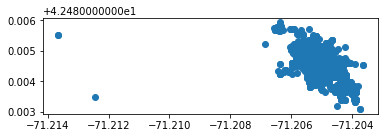

In [65]:
# Plot locations
import matplotlib.pyplot as plt
gdf.plot()

In [22]:
gdf.head()

,ogc_fid,_id,create_date,geolocation_floor,geolocation_latitude,geolocation_longitude,navv_jobid,log_id,navv_user_id,wkb_geometry,...,ack_to_inp,acknowledged_to_inprogress,inp_to_cmp,inprogress_to_completed,pnd_to_cmp,pending_to_completed,num_of_delays,total_delay_time,unique_join_id,geometry
0,13613,617fde04beb1bf0026c7432f,2021-11-01 07:31:00.115-05,2,42.484540862960884,-71.20446605207061,617fc9ebbeb1bf0026c70e4a,1052737,5f2c2dde779144001ef05c39,0101000020E61000000EFF5B6F053E454046B2C7F815CD...,...,0m,0,17m,17,19m,19,0,0m,1,POINT (-71.20447 42.48454)
1,13613,617fde04beb1bf0026c7432f,2021-11-01 07:31:00.115-05,2,42.484540862960884,-71.20446605207061,617fc9ebbeb1bf0026c70e4a,1052737,5f2c2dde779144001ef05c39,0101000020E61000000EFF5B6F053E454046B2C7F815CD...,...,0m,0,17m,17,19m,19,0,0m,2,POINT (-71.20447 42.48454)
2,16610,617fe200beb1bf0026c74ed8,2021-11-01 07:48:00.047-05,0,42.48432458602151,-71.20486794976138,617fc9ebbeb1bf0026c70e4a,1053736,5f2c2dde779144001ef05c39,0101000020E610000039CE1859FE3D4540510E768E1CCD...,...,0m,0,17m,17,19m,19,0,0m,3,POINT (-71.20487 42.48432)
3,13316,617fddc8beb1bf0026c7427b,2021-11-01 07:30:00.054-05,2,42.48453842928656,-71.20446174913087,617fc9ebbeb1bf0026c70e4a,1052677,5f2c2dde779144001ef05c39,0101000020E610000072B8F15A053E45403473BBE615CD...,...,0m,0,17m,17,19m,,0,0m,4,POINT (-71.20446 42.48454)
4,13612,617fde03beb1bf0026c7432e,2021-11-01 07:30:59.718-05,2,42.48447884257201,-71.20446388203038,617fd0c2beb1bf0026c71b33,623251,5fe0cfc183ac4b0018891cf0,0101000020E6100000B1391867033E454028A2ADEF15CD...,...,0m,0,17m,17,19m,19,0,0m,5,POINT (-71.20446 42.48448)


Table join based on same key. See https://automating-gis-processes.github.io/2016/Lesson3-table-join.html

In [ ]:
''' PURPOSE: Table join to join epoch timestamp from Epic data with Location data.'''
epicDataDf = gpd.read_file('geopandas_input/LaheyTransport Data_v2b_FromJessica.csv') 

mergedLocationDf = gdf.merge(epicDataDf, on='epoch_of_status_change')

In [73]:
''' PURPOSE: Convert points to lines in order of timestamp order by job_id '''
import geopandas as gpd
from shapely.geometry import LineString

# Sort dataframe by the timestamp & reset index
sortedDf = gdf.sort_values('create_date').reset_index(drop=True)

# Group the points by the track 
# sortedDf_grouped = sortedDf.groupby(['user_id']).agg({'geometry':list})
                                                # .agg(['count'])#,'mean','std','max','min']) 
''' Get count of # geometry points in the list inside geometry field '''
sortedDf_grouped = sortedDf.groupby(['epicjobid']).agg({'geometry':list})
sortedDf_grouped['count_pnts'] = sortedDf_grouped['geometry'].map(lambda x: len(x))

''' Only select points where there are at least 2 points to make a track line from status points. '''
sortedDf_grouped_for_lines = sortedDf_grouped[sortedDf_grouped['count_pnts'] > 1 ]
sortedDf_grouped_for_lines


,geometry,count_pnts
epicjobid,,
1394072,"[POINT (-71.20481491391648 42.48409235886046),...",12
1394077,"[POINT (-71.2055168450057 42.48516939312493), ...",13
1394080,"[POINT (-71.2057802279669 42.485043177981865),...",12
1394081,"[POINT (-71.20515139508427 42.48464765963607),...",19
1394082,"[POINT (-71.20541228937603 42.48513418412176),...",16
...,...,...
1398583,"[POINT (-71.20564167790128 42.48509162020576),...",18
1398587,"[POINT (-71.20498622724612 42.48438718088776),...",17
1398596,"[POINT (-71.20554234391311 42.48470071979631),...",8


In [74]:
''' PURPOSE: Convert points to lines in order of timestamp order by job_id '''
import geopandas as gpd
from shapely.geometry import LineString

''' IMPORTANT!! Don't run again because data need to be in new format of LINESTRING(-71.123, -71.3456)
# sortedDf_grouped_for_lines['geometry'] = sortedDf_grouped_for_lines['geometry'].apply(lambda x: LineString(x))


C:\Users\Kim\AppData\Local\Temp\ipykernel_10400\3353233707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sortedDf_grouped_for_lines['geometry'] = sortedDf_grouped_for_lines['geometry'].apply(lambda x: LineString(x))


,geometry,count_pnts
epicjobid,,
1394072,"LINESTRING (-71.20481 42.48409, -71.20447 42.4...",12
1394077,"LINESTRING (-71.20552 42.48517, -71.20552 42.4...",13
1394080,"LINESTRING (-71.20578 42.48504, -71.20578 42.4...",12
1394081,"LINESTRING (-71.20515 42.48465, -71.20537 42.4...",19
1394082,"LINESTRING (-71.20541 42.48513, -71.20449 42.4...",16


In [76]:
# Make into GeoDataframe
sortedDf_grouped_gdf = gpd.GeoDataFrame(sortedDf_grouped_for_lines)
sortedDf_grouped_gdf.head()
# fp = r"geopandas_output/user_id_location_track_lines.geojson"
fp = r"geopandas_output/jobid_location_track_lines_joined_epic.geojson"
sortedDf_grouped_gdf.to_file(fp, driver='GeoJSON', encoding="utf-8")
    
sortedDf_grouped_gdf.head()

,geometry,count_pnts
epicjobid,,
1394072,"LINESTRING (-71.20481 42.48409, -71.20447 42.4...",12
1394077,"LINESTRING (-71.20552 42.48517, -71.20552 42.4...",13
1394080,"LINESTRING (-71.20578 42.48504, -71.20578 42.4...",12
1394081,"LINESTRING (-71.20515 42.48465, -71.20537 42.4...",19
1394082,"LINESTRING (-71.20541 42.48513, -71.20449 42.4...",16
